In [1]:
# best syn model r data, slny: switchh label, negated yaw

In [2]:
import os, argparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import wandb

import datasets
# from utils import select_device, natural_keys, gazeto3d, angular, getArch
from utils import select_device, natural_keys, gazeto3d, angular, getArch
from model import L2CS

In [3]:
# check if we have the correct number of checkpoint files 
ppath ='/project/results/soutput/snapshots/' 
for fold in range(15):
    foldstr = f"fold{fold:0>2}"
    cpath =os.path.join(ppath, foldstr)
    files = os.listdir(cpath)
    print(len(files), end=" ")

61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 

In [4]:
args = argparse.Namespace()
args.gazeMpiimage_dir = '/project/data/Image'  # syn data 
args.gazeMpiilabel_dir = '/project/data/Label'  # syn label
args.dataset = 'mpiigaze'
args.snapshot='/project/results/soutput/snapshots/'  # real data model
args.gpu_id = '0,1,2,3'
args.gpu_id = '0'
args.batch_size = 20
args.arch = 'ResNet50'
args.bins=28
args.angle = 180
args.bin_width = 4


In [5]:
batch_size=args.batch_size
arch=args.arch
data_set=args.dataset
snapshot_path = args.snapshot
bins=args.bins
angle=args.angle
bin_width=args.bin_width
cudnn.enabled = True
gazeMpiimage_dir = args.gazeMpiimage_dir
gazeMpiilabel_dir = args.gazeMpiilabel_dir

In [6]:
!ls ../results

README	aoutput  daoutput  output  rsoutput  soutput  sroutput


In [7]:
gpu = select_device(args.gpu_id, batch_size=args.batch_size)
transformations = transforms.Compose([
    transforms.Resize(448),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model_used=getArch(arch, bins)  #resnet50 and 28 bins

In [8]:
def run_fold(fold, pitch_xs, pitch_ys, yaw_xs, yaw_ys, pitch_errs, yaw_errs):
    
    gaze_dataset=datasets.Mpiigaze(testlabelpathcombined, gazeMpiimage_dir, transformations, False, angle, fold)

    test_loader = torch.utils.data.DataLoader(
        dataset=gaze_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True)

    # list all 60 epochs of the fold for testing
    folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
    folder.sort(key=natural_keys)
    folder.pop(-1)
    
    
    
    for epochs in folder: 
        x = ''.join(filter(lambda i: i.isdigit(), epochs))
        x = int(x)
        if x != BEST_EPOCH:
            continue
        #         print(f"epochs={epochs}")
        model=model_used
        checkpoint = torch.load(os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epochs))
        #         print(f"checkpoint={checkpoint}")
        saved_state_dict = checkpoint['model_state_dict']
        model= nn.DataParallel(model,device_ids=[0])
        model.load_state_dict(saved_state_dict)
        model.cuda(gpu)
        model.eval()
        total = 0
        idx_tensor = [idx for idx in range(28)]
        idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
        avg_error = .0

        print(f"epochs={epochs}")

        with torch.no_grad():
            for j, (images, labels, cont_labels, name) in enumerate(test_loader):
        #                 print(f"name={name}")
                images = Variable(images).cuda(gpu)
                total += cont_labels.size(0)

                label_pitch = cont_labels[:,0].float()*np.pi/180
                label_yaw = cont_labels[:,1].float()*np.pi/180

                gaze_pitch, gaze_yaw = model(images)

                # Binned predictions
                _, pitch_bpred = torch.max(gaze_pitch.data, 1)
                _, yaw_bpred = torch.max(gaze_yaw.data, 1)

                # Continuous predictions
                pitch_predicted = softmax(gaze_pitch)
                yaw_predicted = softmax(gaze_yaw)

                # mapping from binned (0 to 28) to angels (-42 to 42)                
                pitch_predicted = \
                    torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 42
                yaw_predicted = \
                    torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 42

                pitch_predicted = pitch_predicted*np.pi/180
                yaw_predicted = yaw_predicted*np.pi/180

                ## switch label, reverse yao
                label_pitch, label_yaw = label_yaw, label_pitch*(-1.0)

                pitch_errors = (pitch_predicted - label_pitch)*180/np.pi
                tdict = dict(zip(name, pitch_errors))
                pitch_errs.update(tdict)

                yaw_errors = (yaw_predicted - label_yaw)*180/np.pi
                tdict = dict(zip(name, yaw_errors))
                yaw_errs.update(tdict)

                label_pitch = label_pitch*180.0/np.pi
                label_yaw = label_yaw*180/np.pi
                pitch_xs.extend(label_pitch.numpy())
                pitch_ys.extend(pitch_errors.numpy())
                yaw_xs.extend(label_yaw.numpy())
                yaw_ys.extend(yaw_errors.numpy())
                
                

In [9]:
%%time

pitch_errs = {}
yaw_errs = {}

pitch_xs = []
pitch_ys = []
yaw_xs = []
yaw_ys =[]

BEST_EPOCH = 7

folder = os.listdir(gazeMpiilabel_dir)
folder.sort()  #individual label files
testlabelpathcombined = [os.path.join(args.gazeMpiilabel_dir, j) for j in folder] 

# print(testlabelpathcombined)

for fold in range(15):
    print(f"fold={fold}")
    
    now = datetime.utcnow()
    now = now.astimezone(timezone('US/Pacific'))
    date_format='%m/%d/%Y %H:%M:%S'
    now = now.strftime(date_format)       

    softmax = nn.Softmax(dim=1)
    configuration = (f"\ntest configuration equal gpu_id={gpu}, batch_size={batch_size}, model_arch={arch}\n"
                     f"Start testing dataset={data_set}, FOLD={fold} --{now}---------")
    print(configuration)

    run_fold(fold, pitch_xs, pitch_ys, yaw_xs, yaw_ys, pitch_errs, yaw_errs)
    
                

fold=0

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=0 --06/22/2022 19:21:41---------
0 items removed from dataset that have an angle > 180
epochs=epoch_7.pkl
fold=1

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=1 --06/22/2022 19:21:59---------
0 items removed from dataset that have an angle > 180
epochs=epoch_7.pkl
fold=2

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=2 --06/22/2022 19:22:11---------
0 items removed from dataset that have an angle > 180
epochs=epoch_7.pkl
fold=3

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=3 --06/22/2022 19:22:23---------
0 items removed from dataset that have an angle > 180
epochs=epoch_7.pkl
fold=4

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing

In [10]:
pitch_errs = dict(sorted(pitch_errs.items(), key=lambda item: item[1], reverse=True))
yaw_errs = dict(sorted(yaw_errs.items(), key=lambda item: item[1], reverse=True))

pitch_errors = np.array(list(pitch_errs.values()))
yaw_errors = np.array(list(yaw_errs.values()))

wandb: Currently logged in as: synthesis-ai (use `wandb login --relogin` to force relogin)


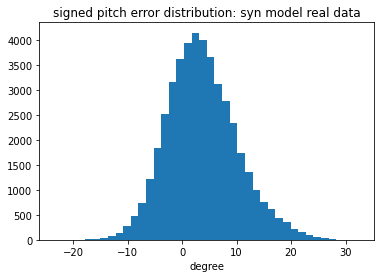

In [11]:
with wandb.init(project="31 best syn model real data SLNY") as run:
    plt.hist(pitch_errors, bins=40)
    plt.title("signed pitch error distribution: syn model real data")
    plt.xlabel("degree")
    run.log({"data":wandb.Image(plt)})

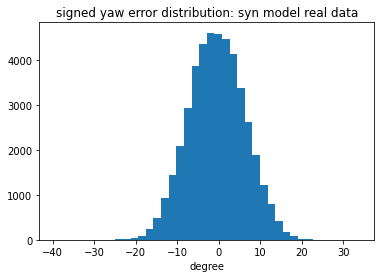

In [12]:
with wandb.init(project="31 best syn model real data SLNY") as run:
    plt.hist(yaw_errors, bins=40)
    plt.title("signed yaw error distribution: syn model real data")
    plt.xlabel("degree")
    run.log({"data":wandb.Image(plt)})

In [13]:
with wandb.init(project="31 best syn model real data SLNY") as run:
    data = [[x, y] for (x, y) in zip(pitch_xs, pitch_ys)]
    table = wandb.Table(data=data, columns = ["truth_degree", "error_degree"])
    wandb.log({"pitch_error_scatter" : wandb.plot.scatter(table, "truth_degree", "error_degree", title="pitch error vs ground truth")})


In [14]:
with wandb.init(project="31 best syn model real data SLNY") as run:
    data = [[x, y] for (x, y) in zip(yaw_xs, yaw_ys)]
    table = wandb.Table(data=data, columns = ["truth_degree", "error_degree"])
    wandb.log({"yaw_error_scatter" : wandb.plot.scatter(table, "truth_degree", "error_degree", title="yaw error vs ground truth")})
